In [1]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Import modules
from cenpy import products

import osmnx as ox 

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString

/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Part 1

In [2]:
# Import data
df = pd.read_csv('/Users/ivanduse/Desktop/School/590/lab5/california_house_prices.csv')

# Read dataset
coast = gpd.read_file('/Users/ivanduse/Desktop/School/590/lab5/california_coastline.shp')

In [3]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf = gdf.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
gdf_utm = gdf.to_crs('EPSG:32610')
coast_utm = coast.to_crs('EPSG:32610')

In [4]:
# Compute distance to coast
distance_to_coast = []
for i in range(gdf_utm.shape[0]):
    distance_to_coast.append(coast_utm.distance(gdf_utm['geometry'].iloc[i]).min())
    
# Add to DataFrame
gdf_utm['distance_to_coast'] = distance_to_coast

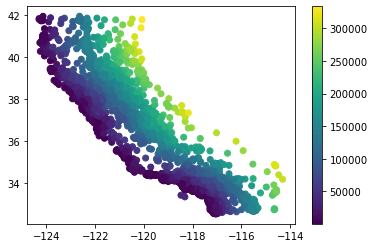

In [5]:
# Quickly check that it worked!
plt.scatter(gdf_utm['longitude'], gdf_utm['latitude'], c=gdf_utm['distance_to_coast'])
plt.colorbar()

## Question 1 (10 points): 

To start, make a **new** `jupyter notebook` called `lab5_submission.ipynb` and work through the following tasks. 

The first task is answer the following questions using some of the methods we have covered in the lecture/demo. 


#### 1a * How many houses are in this dataset?


In [6]:
gdf_utm.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'geometry', 'distance_to_coast'],
      dtype='object')

In [7]:
total_houses = gdf_utm['households'].sum()
print (total_houses)

7798603


#### 1b* How many **features** are there for predicting house price? 


In [8]:
gdf_utm.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'geometry', 'distance_to_coast'],
      dtype='object')

In [9]:
print(f'{len(gdf_utm.columns)}')

11


#### 1c * Are there any null values in this dataset?


In [10]:
gdf_utm.isnull().values.any()

False

###### There are no null values

#### 1c Which three variables are best correlated with house price (include correlation coefficients)?


In [11]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

# Display just house value correlations
top_3 = corr_matrix["median_house_value"].sort_values(ascending= False)
bottom_3 = corr_matrix["median_house_value"].sort_values(ascending= False)

In [12]:
top_3=top_3.abs().sort_values(ascending=False)

In [13]:
print(top_3[1:4])

median_income        0.668566
distance_to_coast    0.505078
latitude             0.173908
Name: median_house_value, dtype: float64


#### * Which three variables are least correlated with house price (include correlation coefficients)?


In [14]:
bottom_3 = bottom_3.abs().sort_values(ascending=True)

In [15]:
print(bottom_3[0:3])

housing_median_age    0.014355
longitude             0.020092
population            0.020930
Name: median_house_value, dtype: float64


# Part 2

In [16]:
# Import data
df2 = pd.read_csv('/Users/ivanduse/Desktop/School/590/lab5/seattle_house_prices.csv')

In [17]:
df2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,lat,long
0,538000,3,2.25,2570,7242,1951,47.7210,-122.319
1,180000,2,1.00,770,10000,1933,47.7379,-122.233
2,604000,4,3.00,1960,5000,1965,47.5208,-122.393
3,510000,3,2.00,1680,8080,1987,47.6168,-122.045
4,1230000,4,4.50,5420,101930,2001,47.6561,-122.005


In [18]:
# Convert DataFrame to GeoDataFrame
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['long'], df2['lat']))
gdf2 = gdf2.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
sea = gdf2.to_crs('EPSG:32610')

In [19]:
sea['long'].values.min()

-122.519

### I notice that this graph of Seattle and contains almost all of King County which could skew some of the data. From the census data I am going to pull in both median income of households and # of College degrees in a specific area. 

In [20]:
# Import modules
from cenpy import products

In [21]:
# Define product
acs = products.ACS(2019)

In [22]:
# Print list of variables
acs.filter_variables('B19013')

,label,concept,predicateType,group,limit,predicateOnly,hasGeoCollectionSupport,attributes,required
B19013E_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013E,0,NaN,NaN,"B19013E_001EA,B19013E_001M,B19013E_001MA",NaN
B19013D_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013D,0,NaN,NaN,"B19013D_001EA,B19013D_001M,B19013D_001MA",NaN
B19013I_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013I,0,NaN,NaN,"B19013I_001EA,B19013I_001M,B19013I_001MA",NaN
B19013A_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013A,0,NaN,NaN,"B19013A_001EA,B19013A_001M,B19013A_001MA",NaN
B19013F_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013F,0,NaN,NaN,"B19013F_001EA,B19013F_001M,B19013F_001MA",NaN
B19013G_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013G,0,NaN,NaN,"B19013G_001EA,B19013G_001M,B19013G_001MA",NaN
B19013B_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013B,0,NaN,NaN,"B19013B_001EA,B19013B_001M,B19013B_001MA",NaN
B19013C_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013C,0,NaN,NaN,"B19013C_001EA,B19013C_001M,B19013C_001MA",NaN
B19013_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013,0,NaN,NaN,"B19013_001EA,B19013_001M,B19013_001MA",NaN
B19013H_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013H,0,NaN,NaN,"B19013H_001EA,B19013H_001M,B19013H_001MA",NaN


In [23]:
acs.filter_tables('PROPERTY', by='description')


,description,columns
table_name,,


In [24]:
# Download data
king_income = products.ACS(2019).from_county('King County, WA', level='tract',
                                        variables=['B19013_001E', 'B15012_001E']) # don't worry about the deprecation message!

/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindfu

In [25]:
king_income.head()

,GEOID,geometry,B15012_001E,B19013_001E,NAME,state,county,tract
0,53033005801,"POLYGON ((-13625108.930 6050237.370, -13625075...",3601.0,98281.0,"Census Tract 58.01, King County, Washington",53,033,005801
1,53033030306,"POLYGON ((-13628089.290 5995123.360, -13627240...",1223.0,92026.0,"Census Tract 303.06, King County, Washington",53,033,030306
2,53033009600,"POLYGON ((-13626018.630 6038448.040, -13625500...",3442.0,132889.0,"Census Tract 96, King County, Washington",53,033,009600
3,53033004700,"POLYGON ((-13624129.760 6051792.900, -13624122...",7315.0,96745.0,"Census Tract 47, King County, Washington",53,033,004700
4,53033020800,"POLYGON ((-13624777.750 6067580.420, -13623993...",2033.0,116563.0,"Census Tract 208, King County, Washington",53,033,020800


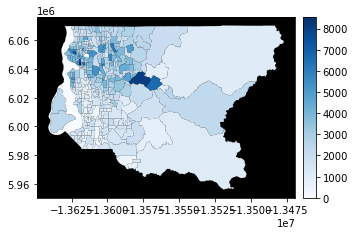

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
##number of college degrees in area

# Plot map
f, ax = plt.subplots(1, 1, figsize=(5,5))

# These two lines make the colorbar the same size as the axes.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

king_income.plot('B15012_001E', ax=ax, cmap='Blues', legend=True, cax=cax)

# Change background color to black
ax.set_facecolor('k')

# Disable scientific notation for legend values
plt.ticklabel_format(style='plain')

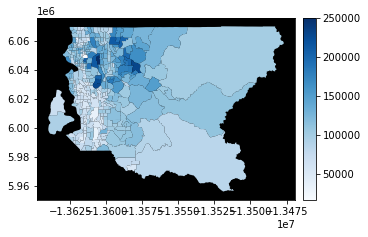

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#median income in area

# Plot map
f, ax = plt.subplots(1, 1, figsize=(5,5))

# These two lines make the colorbar the same size as the axes.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

king_income.plot('B19013_001E', ax=ax, cmap='Blues', legend=True, cax=cax)

# Change background color to black
ax.set_facecolor('k')

# Disable scientific notation for legend values
plt.ticklabel_format(style='plain')

In [28]:
king = king_income.to_crs('EPSG:32610')

In [29]:
from geopandas import gpd 
points = sea
polys = king
SeattleTract = gpd.sjoin(points, polys, op='within') 

/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [30]:
SeattleTract

,price,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,lat,long,geometry,index_right,GEOID,B15012_001E,B19013_001E,NAME,state,county,tract
0,538000,3,2.25,2570,7242,1951,47.7210,-122.319,POINT (551072.719 5285515.861),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
75,315000,3,1.00,960,6634,1952,47.7264,-122.310,POINT (551742.338 5286121.991),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
307,425000,3,1.75,2500,6840,1957,47.7222,-122.320,POINT (550996.552 5285648.570),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
475,365000,4,1.00,1590,7085,1944,47.7315,-122.305,POINT (552112.193 5286692.157),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
915,475000,3,1.75,1700,8432,1977,47.7221,-122.317,POINT (551221.634 5285639.436),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5634,848000,5,1.75,2290,4320,1928,47.6640,-122.310,POINT (551804.109 5279186.906),158,53033005301,1633.0,26413.0,"Census Tract 53.01, King County, Washington",53,033,005301
11136,680000,6,2.00,1670,3000,1911,47.6637,-122.316,POINT (551353.934 5279149.572),158,53033005301,1633.0,26413.0,"Census Tract 53.01, King County, Washington",53,033,005301
11470,210000,4,1.75,2180,28710,1950,47.4050,-122.288,POINT (553719.705 5250417.611),165,53033029101,936.0,70625.0,"Census Tract 291.01, King County, Washington",53,033,029101
15608,242000,3,1.75,1310,9645,1979,47.4051,-122.290,POINT (553568.706 5250427.345),165,53033029101,936.0,70625.0,"Census Tract 291.01, King County, Washington",53,033,029101


In [31]:
SeattleTract.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,lat,long,geometry,index_right,GEOID,B15012_001E,B19013_001E,NAME,state,county,tract
0,538000,3,2.25,2570,7242,1951,47.7210,-122.319,POINT (551072.719 5285515.861),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
75,315000,3,1.00,960,6634,1952,47.7264,-122.310,POINT (551742.338 5286121.991),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
307,425000,3,1.75,2500,6840,1957,47.7222,-122.320,POINT (550996.552 5285648.570),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
475,365000,4,1.00,1590,7085,1944,47.7315,-122.305,POINT (552112.193 5286692.157),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200
915,475000,3,1.75,1700,8432,1977,47.7221,-122.317,POINT (551221.634 5285639.436),365,53033000200,4543.0,77463.0,"Census Tract 2, King County, Washington",53,033,000200


### Next I wanted some geographic variables.. I added proximity to schools and hospitals. Although these did not correlate as well as I hoped.

In [32]:
# Read dataset in for school locations
schools = gpd.read_file('/Users/ivanduse/Desktop/School/590/lab5/School_Sites_in_King_County___schsite_point/School_Sites_in_King_County___schsite_point.shp')

In [33]:
#Reproject
schools_utm = schools.to_crs('EPSG:32610')

In [34]:
# Compute distance to schhool
distance_to_school = []
for i in range(SeattleTract.shape[0]):
    distance_to_school.append(schools_utm.distance(SeattleTract['geometry'].iloc[i]).min())
    
 # Add to DataFrame
SeattleTract['distance_to_school'] = distance_to_school
    

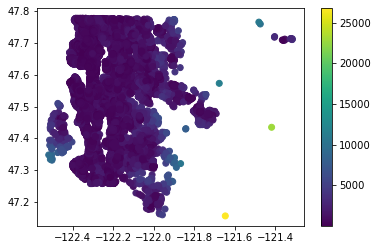

In [35]:
# Quickly check that it worked!
plt.scatter(SeattleTract['long'], SeattleTract['lat'], c=SeattleTract['distance_to_school'])
plt.colorbar()

In [36]:
# Compute correlation matrix
corr_matrix = SeattleTract.corr()

# Display just house value correlations
corr_matrix["price"].sort_values(ascending= False)

price                 1.000000
sqft_living           0.702296
bathrooms             0.524395
B19013_001E           0.509853
B15012_001E           0.356471
bedrooms              0.315804
lat                   0.308082
sqft_lot              0.090125
index_right           0.053405
yr_built              0.052453
distance_to_school    0.029340
long                  0.020092
Name: price, dtype: float64

Distance to schools does not play as big of a role.. Probably because of the huuuuge role of private schools that this GIS layer from the county does not pick up.. 

"https://www.seattletimes.com/seattle-news/data/more-than-1-in-5-seattle-students-are-enrolled-in-private-schools-among-highest-in-nation/"   # link to website

In [37]:
# Read dataset in for school locations
hospitals = gpd.read_file('/Users/ivanduse/Desktop/School/590/lab5/Medical_Facilities_including_Hospitals___medical_facilities_point/Medical_Facilities_including_Hospitals___medical_facilities_point.shp')

In [38]:
#Reproject
hospitals_utm = hospitals.to_crs('EPSG:32610')

In [39]:
# Compute distance to schhool
distance_to_hospital = []
for i in range(SeattleTract.shape[0]):
    distance_to_hospital.append(hospitals_utm.distance(SeattleTract['geometry'].iloc[i]).min())
    
 # Add to DataFrame
SeattleTract['distance_to_hospital'] = distance_to_hospital
    

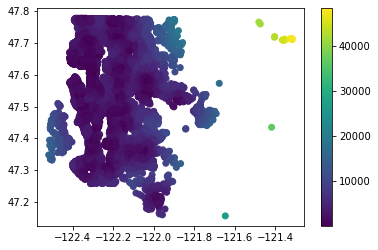

In [40]:
# Quickly check that it worked!
plt.scatter(SeattleTract['long'], SeattleTract['lat'], c=SeattleTract['distance_to_hospital'])
plt.colorbar()

In [41]:
coast2 = gpd.read_file('/Users/ivanduse/Desktop/School/590/lab5/washington_coastline.shp')


In [42]:
coast2_utm = coast2.to_crs('EPSG:32610')

In [43]:
# Compute distance to schhool
distance_to_coasts = []
for i in range(SeattleTract.shape[0]):
    distance_to_coasts.append(coast2_utm.distance(SeattleTract['geometry'].iloc[i]).min())
    
 # Add to DataFrame
SeattleTract['distance_to_coasts'] = distance_to_coasts

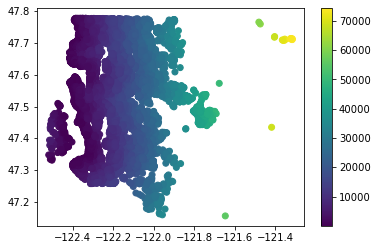

In [44]:
# Quickly check that it worked!
plt.scatter(SeattleTract['long'], SeattleTract['lat'], c=SeattleTract['distance_to_coasts'])
plt.colorbar()

In [45]:
# Compute correlation matrix
corr_matrix = SeattleTract.corr()

# Display just house value correlations
corr_matrix["price"].sort_values(ascending= False)

price                   1.000000
sqft_living             0.702296
bathrooms               0.524395
B19013_001E             0.509853
B15012_001E             0.356471
bedrooms                0.315804
lat                     0.308082
sqft_lot                0.090125
index_right             0.053405
yr_built                0.052453
distance_to_school      0.029340
distance_to_coasts      0.027830
long                    0.020092
distance_to_hospital    0.013175
Name: price, dtype: float64

In [46]:
# Specify type of data
tags = {'natural=water': True}
place = ox.geocode_to_gdf('King County, Washington')


/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [47]:
# Download building geometries from OSM
osmgdf = ox.geometries_from_place('King County, Washington', tags)

/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [48]:
# Count number of non-NaNs in each column
print(osmgdf.shape)

(0, 1)


In [49]:
# Compute correlation matrix
corr_matrix = SeattleTract.corr()

# Display just house value correlations
corr_matrix["price"].sort_values(ascending= False)

price                   1.000000
sqft_living             0.702296
bathrooms               0.524395
B19013_001E             0.509853
B15012_001E             0.356471
bedrooms                0.315804
lat                     0.308082
sqft_lot                0.090125
index_right             0.053405
yr_built                0.052453
distance_to_school      0.029340
distance_to_coasts      0.027830
long                    0.020092
distance_to_hospital    0.013175
Name: price, dtype: float64

In [50]:
# Compute correlation matrix
corr_matrix = SeattleTract.corr()

# Display just house value correlations
corr_matrix["price"].sort_values(ascending= False)

price                   1.000000
sqft_living             0.702296
bathrooms               0.524395
B19013_001E             0.509853
B15012_001E             0.356471
bedrooms                0.315804
lat                     0.308082
sqft_lot                0.090125
index_right             0.053405
yr_built                0.052453
distance_to_school      0.029340
distance_to_coasts      0.027830
long                    0.020092
distance_to_hospital    0.013175
Name: price, dtype: float64

In [66]:
# Import library
from sklearn.preprocessing import StandardScaler

# Define feature list
feature_list =  ['sqft_living', 'bathrooms', 'B19013_001E', 
                 'B15012_001E', 'bedrooms', 'lat','sqft_lot','long','yr_built','distance_to_school','distance_to_hospital','distance_to_coasts']

# Define features and labels 
X = SeattleTract[feature_list]
y = SeattleTract['price']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [67]:
from sklearn.model_selection import train_test_split

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [68]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

In [69]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

144477.3192636935

Random Forest was as low as I could get the price... Within 150,000 dollars of actual!

(0.0, 1500000.0)

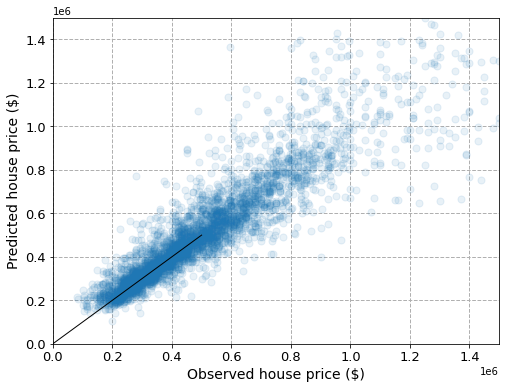

In [70]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,500000], [0, 500000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted house price ($)', fontsize=14)
ax.set_xlabel('Observed house price ($)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,1500000)
ax.set_xlim(0,1500000)

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/Users/ivanduse/opt/anaconda3/envs/lab5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

XG Boost didnt work out quite as well..